In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm

In [19]:
np.random.seed(2013)
n = 10000 # samples
m = 10000 # SNPs
k = 5 # num of covariates

S = np.random.normal(0, 1, size=(n, m)) # SNP matrix
X0 = np.random.uniform(0, 1, size=(n, k)) # covariates matrix 
ones = np.zeros(n) + 1
X = np.append(ones.reshape(n, 1), X0, axis=1)
y = np.random.binomial(1, 0.5, n).reshape(n,1)

# semi-parallel log regression with covariates

fit regression with const matrix(covariates are the same for each SNP for one person), then do 1 iteration of Newton-Rhapsod(NR) with SNP term in regression.

semi-parallel approach is realized in firstly doing one regression with covariates for all SNPs and then doing one iteration of NR for all SNP simultaneously(calculate S_star and not for each column of S separately)

In [21]:
t0 = time.time()
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
p = model.fittedvalues.reshape(n,1)

w = p * (1 - p) # diag matrix with const elem
z = np.log(p / (1 - p)) + (y - p) / (p * (1 - p))
xtw = (X * w).T # X^T * W
U1 = xtw @ z
U2 = np.linalg.solve(xtw @ X, U1) # find betta_t, needed to find z*
z_star = z - X @ U2
U4 = np.linalg.solve(xtw @ X, xtw @ S) 
S_star = S - X @ U4
Str2 = np.sum(w * S_star**2, axis = 0) # m size vector of sums(w_i * s_i^2)
beta = np.sum(z_star * w * S_star, axis=0) / Str2 # m size vect of sums(wi zi si) / str2
err = Str2**-0.5
pval = 2 * stat.norm.cdf(-np.abs(beta / err))

# # Report time
t1 = time.time() - t0
msip = 1e-06 * n * m / t1
print(f"Speed: {msip:.2f} Msips\n")

Speed: 25.02 Msips



In [28]:
(t1 * 76)/ 60

5.062219762802124

non semi-parallel approach - fit regression for each SNP separately

In [17]:
t0 = time.time()
beta_sep = np.zeros(m)
pval_sep = np.zeros(m)
err_sep = np.zeros(m)
for i in range(m):
    X_si = np.append(S[:,i].reshape(n,1), X, axis=1)
    model = sm.GLM(y, X_si, family=sm.families.Binomial()).fit()
    beta_sep[i] = model.params[0]
    pval_sep[i] = model.pvalues[0]
# # Report time
t1 = time.time() - t0
msip_sep = 1e-06 * n * m / t1
print(f"Speed: {msip_sep:.2f} Msips\n")

NameError: name 'msip_sep' is not defined

In [12]:
print(f"Semi-parallel is {msip/msip_sep:.2f} times faster")

Semi-parallel is 47.11 times faster


(array([100.,  85.,  87.,  93., 114., 114., 105.,  92.,  97., 113.]),
 array([0.00103895, 0.10088459, 0.20073023, 0.30057586, 0.4004215 ,
        0.50026714, 0.60011278, 0.69995842, 0.79980406, 0.8996497 ,
        0.99949533]),
 <BarContainer object of 10 artists>)

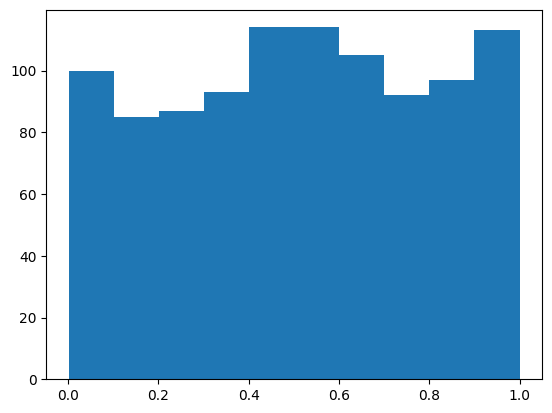

In [109]:
plt.hist(pval_sep)

(array([100.,  85.,  87.,  93., 114., 114., 105.,  92.,  97., 113.]),
 array([0.00103251, 0.1008788 , 0.20072508, 0.30057136, 0.40041764,
        0.50026392, 0.60011021, 0.69995649, 0.79980277, 0.89964905,
        0.99949533]),
 <BarContainer object of 10 artists>)

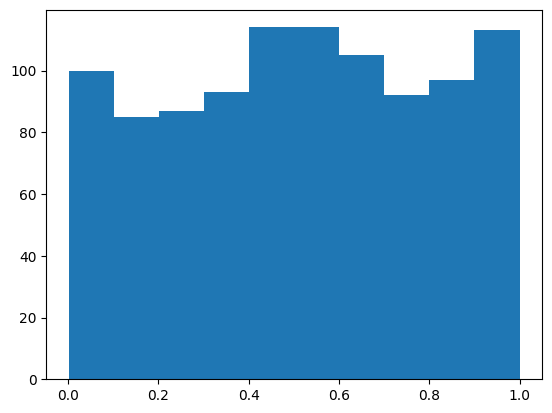

In [117]:
plt.hist(pval)

Difference in p-values predicted by exact and approximate alglorithms

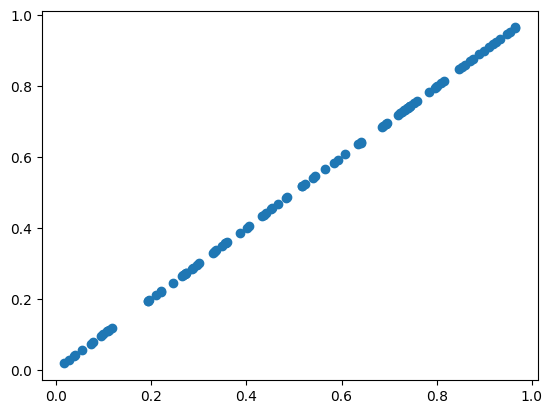

In [11]:
h = 100
p1 = np.zeros(h)
p2 = np.zeros(h)

for i in range(h):
    np.random.seed(i)
    n = 1000 # samples
    m = 1 # SNPs
    k = 5 # num of covariates

    S = np.random.normal(0, 1, size=(n, m)) # SNP matrix
    X0 = np.random.uniform(0, 1, size=(n, k)) # covariates matrix 
    ones = np.zeros(n) + 1
    X = np.append(ones.reshape(n, 1), X0, axis=1)
    y = np.random.binomial(1, 0.5, n).reshape(n,1)

    model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
    p = model.fittedvalues.reshape(n,1)

    w = p * (1 - p) # diag matrix with const elem
    z = np.log(p / (1 - p)) + (y - p) / (p * (1 - p))
    xtw = (X * w).T # X^T * W
    U1 = xtw @ z
    U2 = np.linalg.solve(xtw @ X, U1) # find betta_t, needed to find z*
    z_star = z - X @ U2
    U4 = np.linalg.solve(xtw @ X, xtw @ S) 
    S_star = S - X @ U4
    Str2 = np.sum(w * S_star**2, axis = 0) # m size vector of sums(w_i * s_i^2)
    beta = np.sum(z_star * w * S_star, axis=0) / Str2 # m size vect of sums(wi zi si) / str2
    err = Str2**-0.5
    pval = 2 * stat.norm.cdf(-np.abs(beta / err))

    X_si = np.append(S[:,0].reshape(n,1), X, axis=1)
    model = sm.GLM(y, X_si, family=sm.families.Binomial()).fit()
    pval_sep = model.pvalues[0]

    p1[i] = pval
    p2[i] = pval_sep
       
plt.plot(-np.log10(p1),-np.log10(p2),'o')


In [18]:
0.34/(10000 * 10000)

3.4000000000000003e-09